## Sampling a 4-dimensional MultiVariate Normal distribution (MVN) via the ParaMonte library's ParaDRAM routine    

**The logic of Monte Carlo sampling** is very simple: You have a mathematical objective function defined on a `ndim`-dimensional domain. Typically, this domain is defined on the space of real numbers. In general, understanding and visualizing the structure of such objective functions is an extremely difficult task, if not impossible. As a better alternative, you employ Monte Carlo techniques that can randomly explore the structure of the objective function and find the function's extrema.  

In the following example below, an example of one of the simplest such objective functions, the **Multivariate Normal Distribution (MVN)**, is constructed and sampled using the ParaMonte library samplers, here, the **ParaDRAM** sampler (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo sampler**).  

Suppose we want to sample random points from a [multivariate Normal Probability Density Function (PDF)](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). 

The following Python function `getLogFunc()` returns the natural logarithm of the Probability Density Function of the multivariate Normal PDF. For the moment, let's name this function `getLogFunc_bad()`. The reason for this naming will become clear soon.  

In [1]:
# activate interactive plotting in Jupyter environment
%matplotlib notebook

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

NDIM = 4 # the number of dimensions of the domain of the objective function: MVN

mvn = multivariate_normal   ( mean =  [-10,15.,20.,0.0] # This is the mean of the MVN distribution.
                            , cov = [ [1.0,.45,-.3,0.0] # This is the covariance matrix of the MVN distribution.
                                    , [.45,1.0,0.3,-.2]
                                    , [-.3,0.3,1.0,0.6]
                                    , [0.0,-.2,0.6,1.0]
                                    ]
                            )

def getLogFunc_bad(point): return np.log(mvn.pdf(point))

> Since the mathematical objective functions (e.g., probability density functions) can take extremely small or large values, we often work with their natural logarithms instead. **This is the reason behind the naming convention used in the ParaMonte library for** the user's objective functions: **getLogFunc**, implying that **the user must provide a function that returns the natural logarithm of the target objective function**.  

---  
### Digression  

Notice in the above that we suffixed the objective function with `_bad`. This is for a few **important** reasons:

1. This function's evaluation involves a `log(exp())` term in its definition. If the origin of the `exp()` term is not clear to you, take a look at the definition of the MVN distribution in the link provided above.  This is computational very expensive and in general, is considered a bad implementation.  

1. The evaluation of the function as implemented in the above requires an inverse-covariance matrix on each call made to `getLogFunc_bad()`. This is completely redundant as the value of the covariance matrix does not change throughout the simulation. Consequently, a lot of computational resources are wasted for nothing.  

1. This implementation of the MVN distribution is quite prone to numerical **overflow** and **underflow**, which could cause the simulations to crash at runtime. For example, when the input value for `point` happens to be too far from the `mean` of the MVN distribution, it is likely that the resulting probability density function value for the MVN would be so small that the computer rounds it to zero. Then `np.log(0.0)` in `getLogFunc_bad()` becomes undefined and the simulation crashes, in the best-case scenario and will notice the problem.  

It is, therefore, important to implement a numerically efficient, fault-tolerant MVN PDF calculator that resolves all of the above concerns. This is possible if we take a second look at the equation for the MVN PDF and try directly implement as our objective function,

In [3]:
import numpy as np

# the number of dimensions of the domain of the objective function: MVN

NDIM = 4 

# This is the mean of the MVN distribution.

MEAN =  np.double([-10, 15., 20., 0.0])

# This is the covariance matrix of the MVN distribution.

COVMAT = np.double( [ [1.0,.45,-.3,0.0] 
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] )

# This is the inverse of the covariance matrix of the MVN distribution.

INVCOV = np.linalg.inv(COVMAT)

# This is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point): 
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

Now, let's compare the performance of the two implementations above,

In [4]:
%timeit getLogFunc_bad(np.double([0,0,0,0]))

27.2 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%timeit getLogFunc(np.double([0,0,0,0]))

7.77 µs ± 187 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The good implementation is **more than five times more efficient** than the naive implementation of the objective function!

Now, let's compare the fault-tolerance of the two implementations by assigning large values to the elements of the input `point` array,

In [6]:
getLogFunc(point = NDIM*[10000])

-144906406.5712369

In [7]:
getLogFunc_bad(point = NDIM*[10000])

C:\Users\shahmoradia\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


-inf

Now, this may sound to you like being too meticulous, but, **a good fault-tolerant implementation of the objective function is absolutely essential in Monte Carlo simulations**, and this example objective function here is no exception. The `-inf` value that `getLogFunc_bad()` yields, will certainly lead to a severe catastrophic crash of a Monte Carlo simulation (You can try it below at your own risk!).  

---  
We will sample random points from this objective function by calling the **ParaDRAM** sampler (**Delayed-Rejection Adaptive Metropolis-Hastings Markov Chain Monte Carlo sampler**) of the ParaMonte library.  

## Running a ParaDRAM simulation on a single processor

>**To run the sampler in parallel**, you will have to first save the MPI-enabled script as an external file (see below). Visit the [ParaMonte library's documentation website](http://cdslab.org/paramonte/notes/run/python/) for more information.

In [8]:
import paramonte as pm

---  
### Digression  
We can **get** the ParaMonte library interface version,  

In [9]:
pm.version.interface.get()

'ParaMonte Python Interface Version 1.0.12'

We can also **dump** the ParaMonte library interface version,

In [10]:
pm.version.interface.dump()

'1.0.12'

Similarly, we can also **get** and **dump** the ParaMonte library kernel version,

In [11]:
pm.version.kernel.get()

'ParaMonte Python Kernel Version 1.1.0'

In [12]:
pm.version.kernel.dump()

'1.1.0'

We can also verify the existence of the essential components of the current installation of the ParaMonte Python library on the system,

In [13]:
pm.verify()


:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
::::                                                                                       ::::

       _/_/_/_/                                   _/_/    _/_/
        _/    _/                                  _/_/_/_/_/                     _/
       _/    _/ _/_/_/_/   _/ /_/_/ _/_/_/_/     _/  _/  _/   _/_/   _/_/_/   _/_/_/  _/_/_/
      _/_/_/   _/    _/   _/_/     _/    _/     _/      _/  _/   _/ _/    _/   _/   _/_/_/_/                        
     _/       _/    _/   _/       _/    _/     _/      _/  _/   _/ _/    _/   _/   _/    
  _/_/_/       _/_/_/_/ _/         _/_/_/_/ _/_/_/  _/_/_/  _/_/  _/    _/   _/_/   _/_/_/


                                          ParaMonte
                                   plain powerful parallel
                                     Monte Carlo library
                                        Version 1.0.12

::::                                      

---  
### Setting up the ParaDRAM simulation specifications

Now, define a ParaDRAM sampler instance,  

In [14]:
pmpd = pm.ParaDRAM()

The **simplest scenario** is to **run the simulation with the default specifications** that are appropriately determined by the ParaDRAM sampler. However, for the purpose of clarity reproducibility, we will specify a few simulation specs,

> For a complete list of all ParaDRAM simulation specifications, visit the [ParaDRAM simulation specifications webpage](https://www.cdslab.org/paramonte/notes/usage/paradram/specifications/).  

### The simulation output file names and storage path   
We will store all output files in a directory with the same name as this Jupyter Notebook's name and with the same prefix.  

> By default, all ParaDRAM simulation output files are named properly (see [this page](https://www.cdslab.org/paramonte/notes/usage/paradram/output/) for a review of ParaDRAM simulation output files). **In general, it is a good habit to specify an output file prefix for any ParaDRAM simulation**. This way, the restart of an incomplete simulation, if it happens for some reasons, would be seamless and doable by just rerunning the simulation, without any change of any sort to any parts of the codes or the simulation.  

In [15]:
pmpd.spec.outputFileName = "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial"

### Ensuring the reproducibility of the results  
We will also initialize the random seed to a fixed number to ensure the reproducibility of the simulation results in the future,  

In [16]:
pmpd.spec.randomSeed = 3751

Not so important, but we will also specify a chainSize here, 30000, the number of **unique points** to be sampled from the objective function. This number is much smaller than the default 100,000 unique sample points of the sampler.  

In [17]:
pmpd.spec.chainSize = 30000

### Calling the ParaDRAM sampler  
Note that none of the above specification settings are necessary, but is in general a good habit to define them prior to the simulation.  
We now call the ParaDRAM sampler routine to run the sampling simulation,  

In [25]:
# run the ParaDRAM sampler
pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit: cdslab.org/pm
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's terminal window
ParaDRAM - NOTE: for realtime simulation progress and report.


ParaDRAM - NOTE: To read the generated output files sample or chain files, try the following:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readSample()      # to read the final i.i.d. sample from the output sample file. 
ParaDRAM - NOTE:     pmpd.readChain()       # to read the uniquely-accepted points from the output chain file. 
ParaDRAM - NOTE:     pmpd.readMarkovChain() # to read the Markov Chain. NOT recommended for extremely-large chains.
ParaDRAM - NOTE: 
ParaDRAM - NOTE: Replace 'pmpd' with the name you are using for your ParaDRAM object.
ParaDRAM - NOTE: For more information and examples on the usage, visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte/



This will print the realtime simulation progress information on your **Anaconda prompt window** (not inside your Jupyter notebook). Once the simulation is finished, the ParaDRAM routine generates 5 output files, each of which contains information about certain aspects of the simulation,  

-   [mvn_serial_process_1_report.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_report.txt)  
    This file contains reports about all aspects of the simulation, from the very beginning of the simulation to the very last step, including the postprocessing of the results and final sample refinement.  

-   [mvn_serial_process_1_progress.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_progress.txt)  
    This file contains dynamic realtime information about the simulation progress. The frequency of the progress report to this file depends on the value of the simulation specification `progressReportPeriod`.  

-   [mvn_serial_process_1_sample.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_sample.txt)  
    This file contains the final fully-refined decorrelated i.i.d. random sample from the objective function.  

-   [mvn_serial_process_1_chain.txt](sampling_multivariate_normal_density_function_via_paradram/mvn_serial_process_1_chain.txt)  
    This file contains the Markov chain, generally in either binary or condensed (compact) ASCII format to improve the storage efficiency of the chain on your computer.  



Now, we can read the generated output sample, contained in the file suffixed with `*_sample.txt`.

In [26]:
pmpd.readSample()


ParaDRAM - WARNING: delimiter is neither given as input nor set as a ParaDRAM object property.
ParaDRAM - WARNING: This information is essential for successful reading of the requested sample file(s).
ParaDRAM - WARNING: Proceeding with the default assumption of comma-delimited sample file contents...

ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_sample.txt"
ParaDRAM - NOTE: processing file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\jupyter\Python\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_sample.txt
ParaDRAM - NOTE: reading file contents... done in 0.034666 seconds.
ParaDRAM - NOTE: parsing file contents... done in 0.000468 seconds.
ParaDRAM - NOTE: computing sample correlation matrix... done in 0.007021 seconds.
ParaDRAM - NOTE: computing sample covariance matrix... done in 0.006017 seconds.
ParaDRAM - NOTE: computing autocorrelations... done in 0.082722 

By default, the ParaDRAM sampler generated a highly refined decorrelated final sample, essentially refining the Markov chain for as long as there is any residual auto-correlation in any of the individual variables of the Markov chain that has been sampled. This is an extremely strong and conservative refinement strategy (and it is so for a good reason: to **ensure independent and identically distributed (i.i.d.) samples from the objective function**). 
However, this extreme refinement can be mitigated and controlled by the setting the following ParaDRAM simulation specification variable prior to the simulation run,

In [27]:
pmpd.spec.sampleRefinementCount = 1

Rerun the simulation with this specification set and, you will notice a **three-fold** increase in the final sample size, from `7244` to `22140`. Note that the above specification has to be set **before** running the simulation above if you really want to use it. A value of `1` will cause the ParaDRAM sampler for only one round, which what most people in the MCMC community do.

To quickly visualize the generated sample as a histogram, try,

<IPython.core.display.Javascript object>


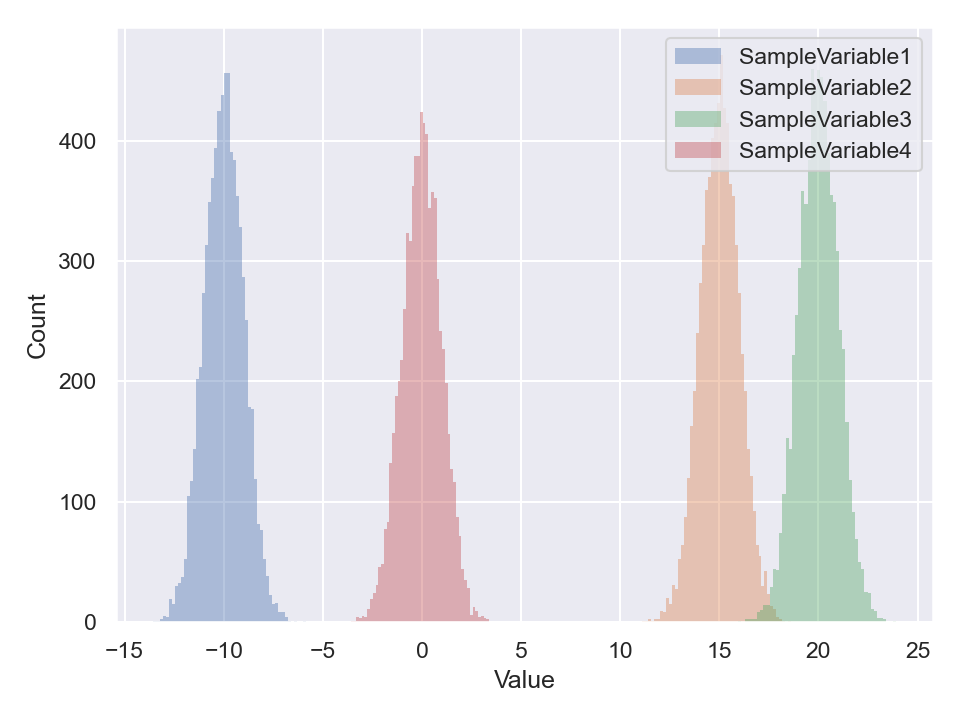

In [28]:
pmpd.sampleList[0].plot.hist()

If the variable names are specified for the sampler before runnign the simulations, the sampler will automatically assign names to each variable. To change the x-label, for example, you can try,

<IPython.core.display.Javascript object>


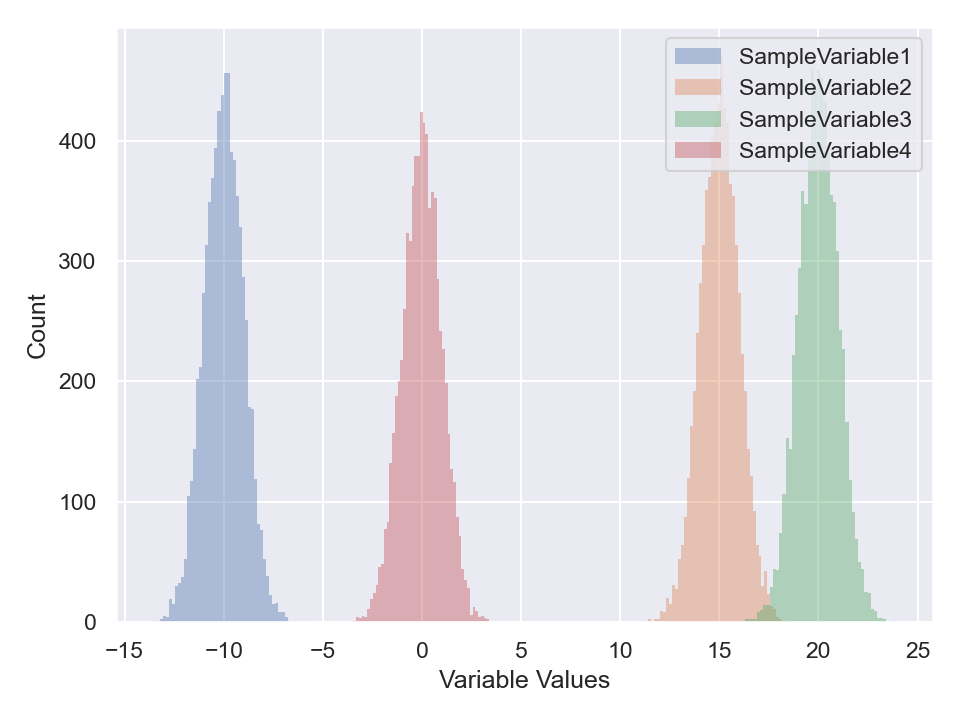

Text(0.5, 31.07499999999998, 'Variable Values')

In [29]:
pmpd.sampleList[0].plot.hist()
pmpd.sampleList[0].plot.hist.currentFig.axes.set_xlabel("Variable Values")

To make a trace-plot of the sample, try,  

<IPython.core.display.Javascript object>


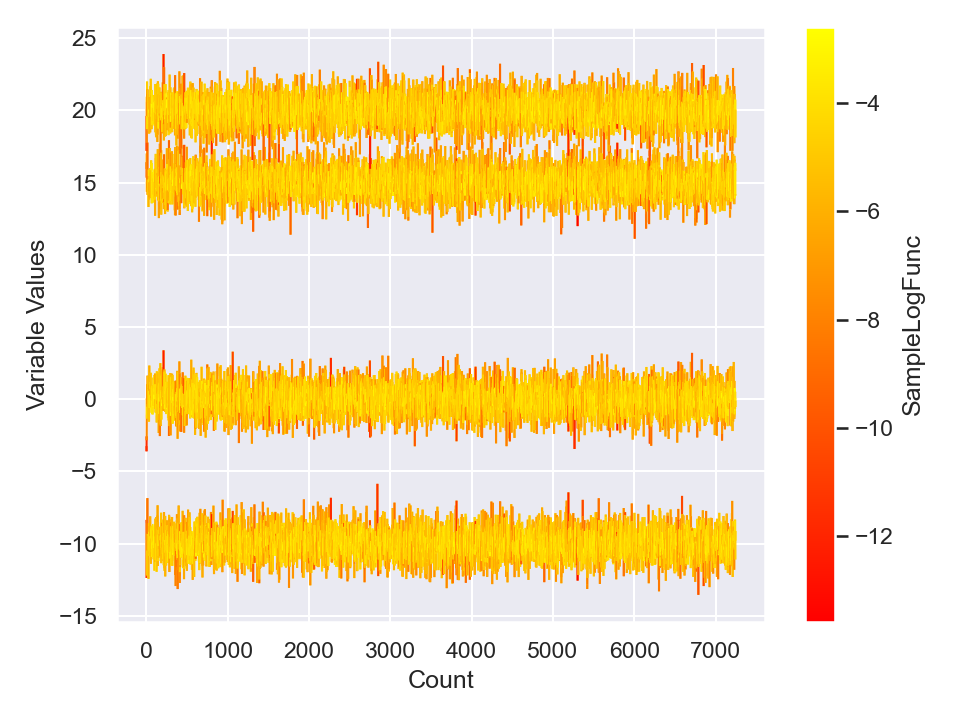

In [30]:
pmpd.sampleList[0].plot.line()

To change the scale of the x-axis, try,  

<IPython.core.display.Javascript object>


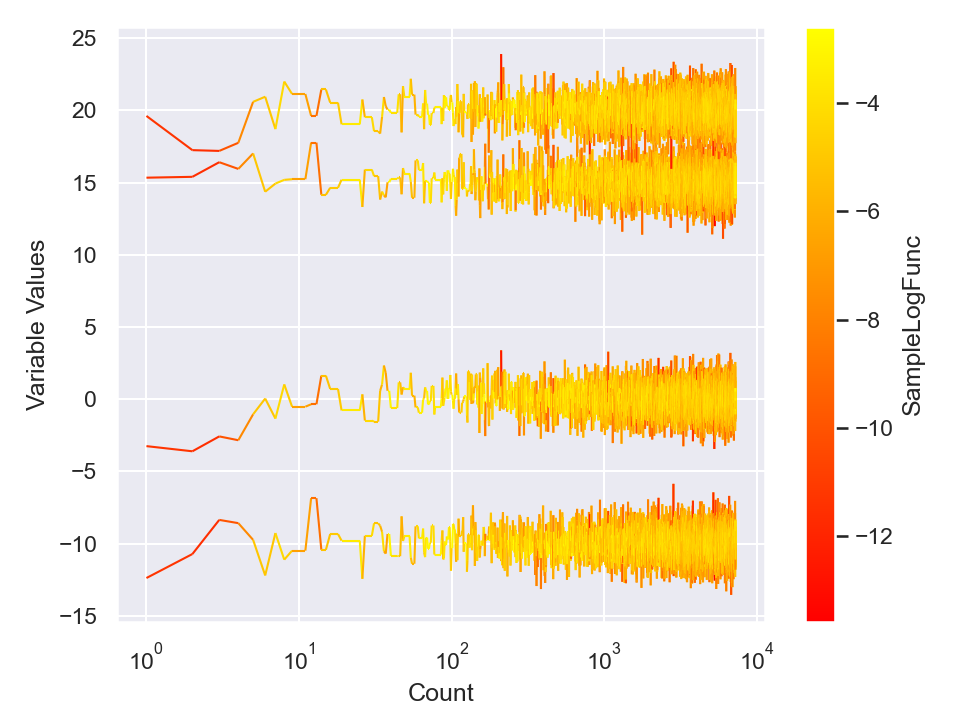

In [31]:
pmpd.sampleList[0].plot.line()
pmpd.sampleList[0].plot.line.currentFig.axes.set_xscale("log")

By default, the color of the line in the trace-plot will represent the value returned by `getLogFunc()` at the given sampled point. To turn the color off, you can instead try,

In [32]:
pmpd.sampleList[0].plot.line.ccolumns

'SampleLogFunc'

<IPython.core.display.Javascript object>


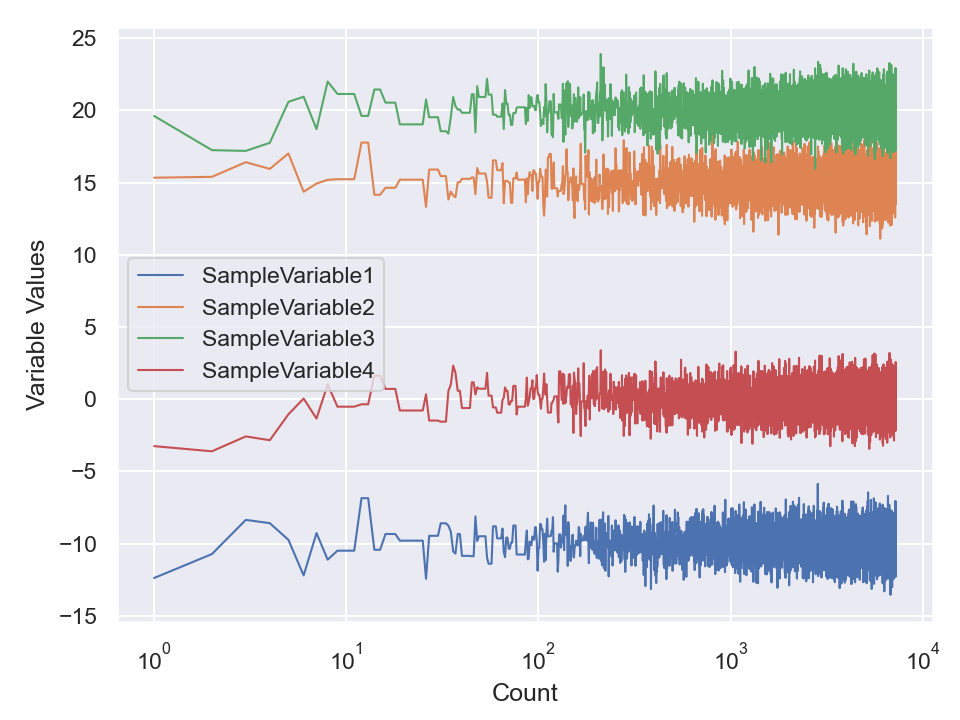

In [33]:
pmpd.sampleList[0].plot.line.ccolumns = None
pmpd.sampleList[0].plot.line()
pmpd.sampleList[0].plot.line.currentFig.axes.set_xscale("log")

There are many other properties of the plot that can be set or modified via the attributes of the `pmpd.sampleList[0].plot.line` object. To see them all, see the documentation of the object via `help(pmpd.sampleList[0].plot.line)`,

To make a scatter trace-plot of the sampled points, try,

<IPython.core.display.Javascript object>


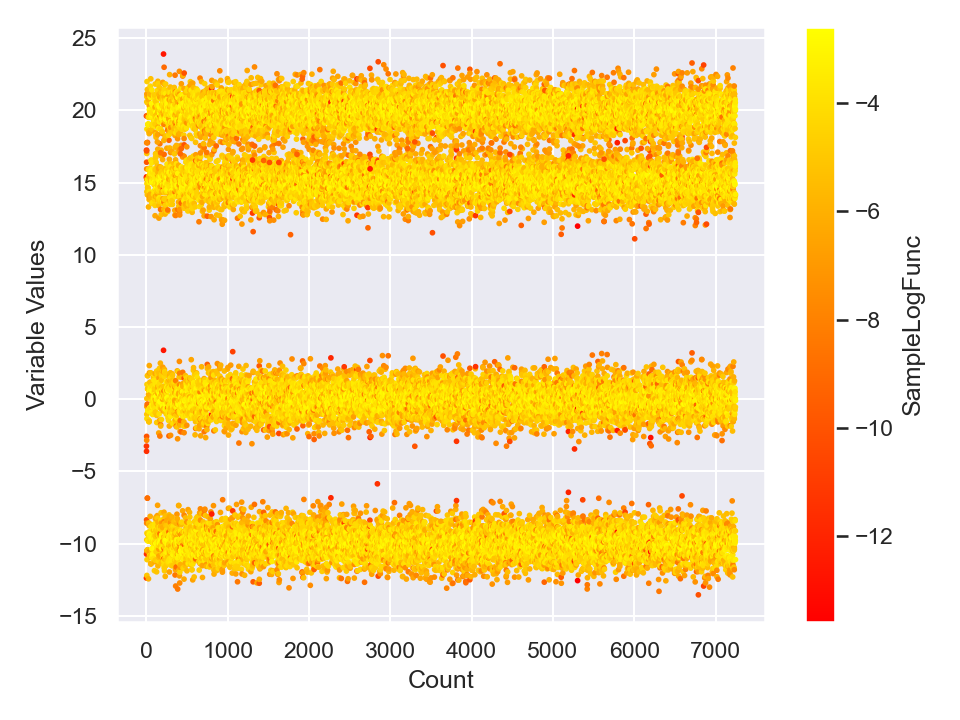

In [34]:
pmpd.sampleList[0].plot.scatter()

Setting or modifying the properties of the scatter plot is identical to the line plot. By default, the sampler makes a scatter plot of all of the sampled variables on top of each other as a function of their order in the sample file. To make the plot more meaning fule, you want to plot individual variables against each other. For example, to make scatter plots of all variables against the `logFunc`, 

In [35]:
variables = pmpd.sampleList[0].plot.scatter.ycolumns.values
variables

array(['SampleVariable1', 'SampleVariable2', 'SampleVariable3',
       'SampleVariable4'], dtype=object)

<IPython.core.display.Javascript object>


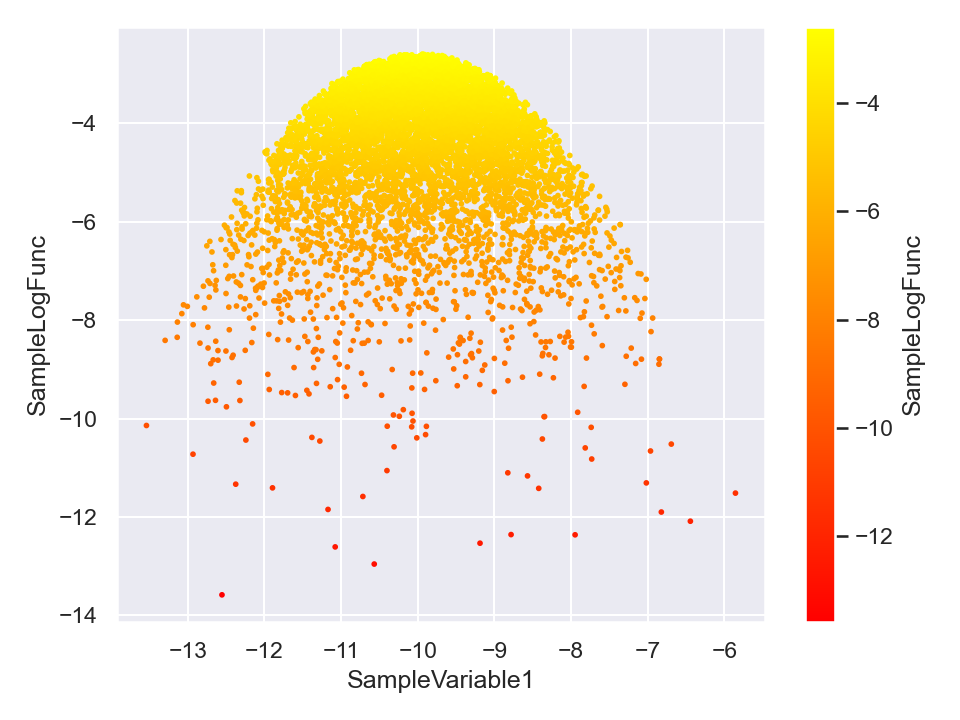

<IPython.core.display.Javascript object>


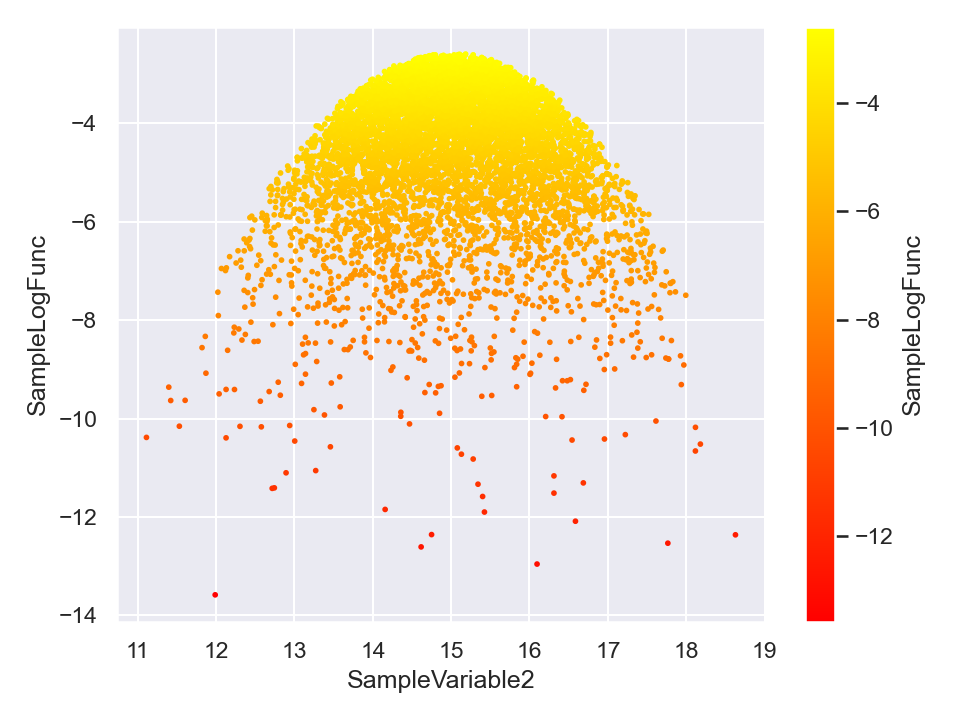

<IPython.core.display.Javascript object>


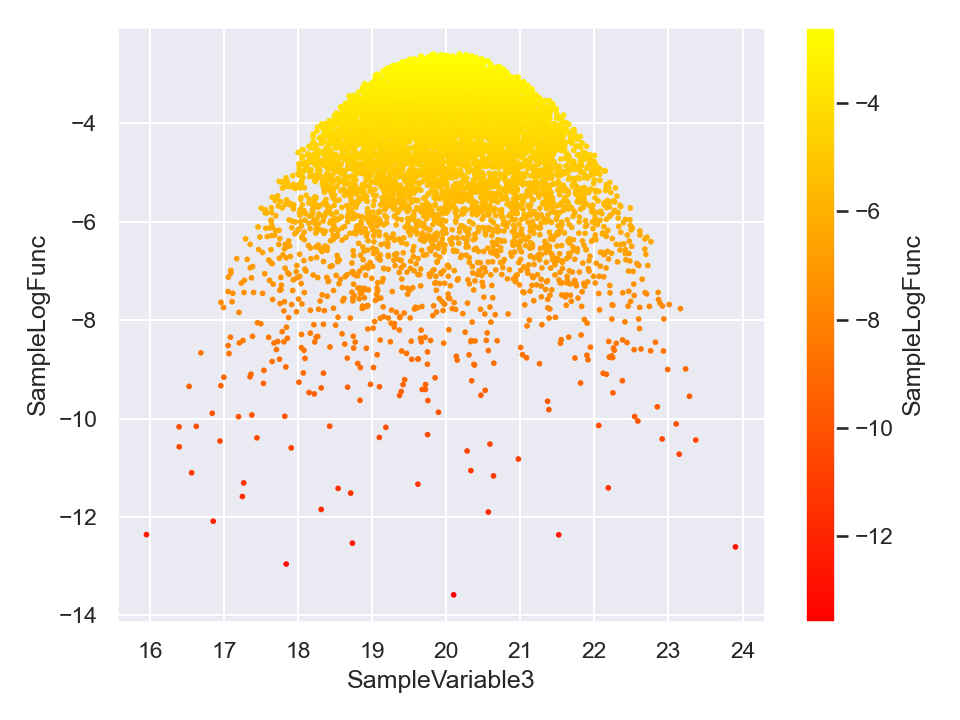

<IPython.core.display.Javascript object>


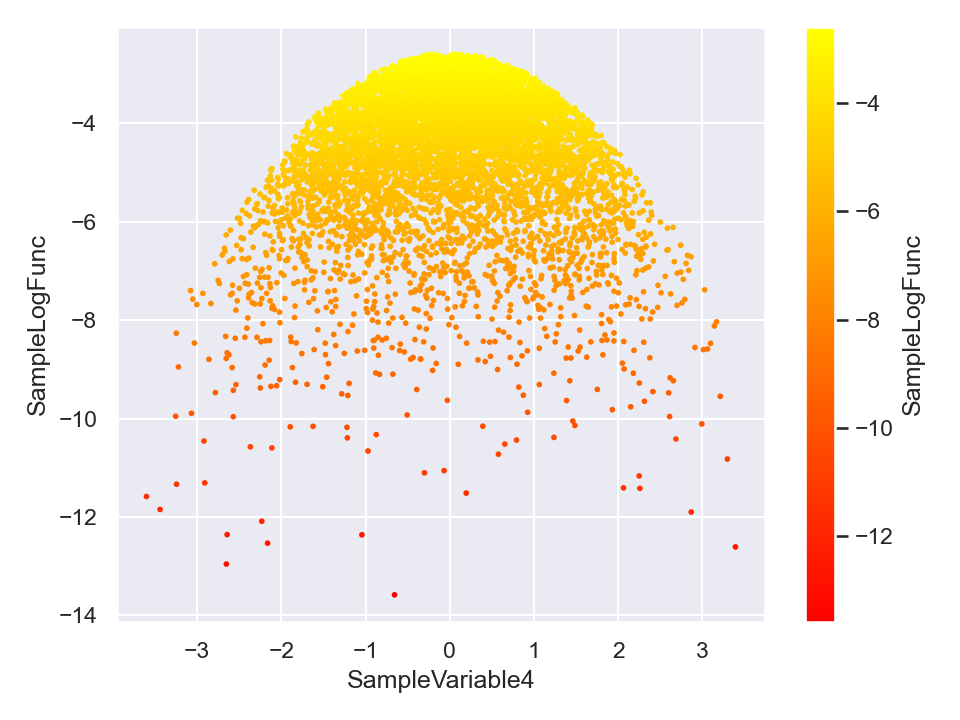

In [36]:
pmpd.sampleList[0].plot.scatter.ycolumns = "SampleLogFunc"
for variable in variables:
    pmpd.sampleList[0].plot.scatter.xcolumns = variable
    pmpd.sampleList[0].plot.scatter()

To make kernel density plots of the sampled points, try (**WARNING**: 2D-kernel density estimates are computationally demanding and depending on the capabilities of your computer may take a long while to finish),

<IPython.core.display.Javascript object>


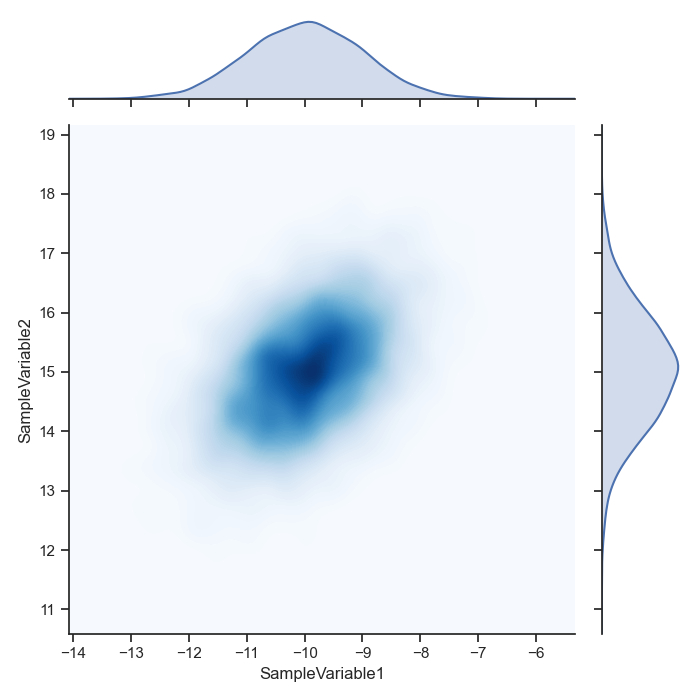

In [37]:
pmpd.sampleList[0].plot.density()

By default, the kernel density plot displays `SampleVariable2` vs. `SampleVariable1`, if no other specifications are made by the user. To see the options, see the attributes of the `pmpd.sampleList[0].plot.density` object by pressing the `tab` key after putting a `.` after `density`.

To make a grid plot of all of the variables against each other, try, (**WARNING**: Depending on the size of your sample, the grid plots can be computationally very demanding. Depending on the capabilities of your computer, the plotting may take a long while to finish. To reduce the computational demand, the sampler plots only the first three sampled variables against each other, by default. This can be overridden by assigning more variable names to the plot's `columns` attribute.)

<IPython.core.display.Javascript object>


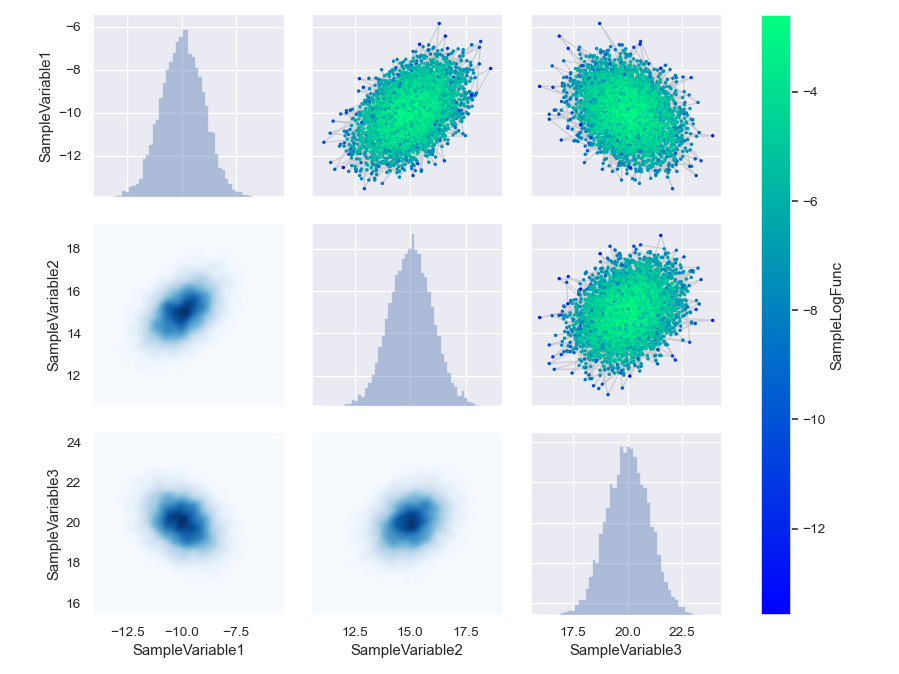

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.061164 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 3: SampleVariable2 - SampleVariable1... done in 1.016724 seconds.
ParaDRAM - NOTE:     2 out of 3: SampleVariable3 - SampleVariable1... done in 0.996664 seconds.
ParaDRAM - NOTE:     3 out of 3: SampleVariable3 - SampleVariable2... done in 1.011686 seconds.
ParaDRAM - NOTE: adding kdeplots... depending on the number of plots, this may take a long while.
ParaDRAM - NOTE:     adding the lower-triangle kdeplots...done in 15.440248 seconds.


In [25]:
pmpd.sampleList[0].plot.grid()

By default, both the KDE plots and line/scatter plots will be drawn. You can skip the plots by setting the `grid` object's attributes `kdecorner=None` or `lscorner=None`. For example,

<IPython.core.display.Javascript object>


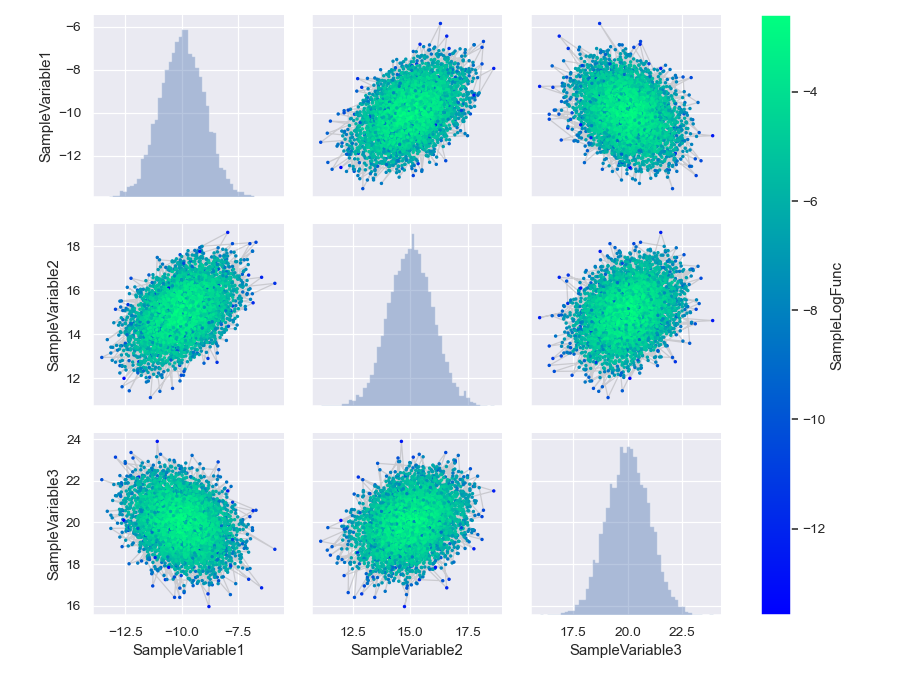

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.089248 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 6: SampleVariable2 - SampleVariable1... done in 1.427807 seconds.
ParaDRAM - NOTE:     2 out of 6: SampleVariable3 - SampleVariable1... done in 1.384191 seconds.
ParaDRAM - NOTE:     3 out of 6: SampleVariable1 - SampleVariable2... done in 1.717079 seconds.
ParaDRAM - NOTE:     4 out of 6: SampleVariable3 - SampleVariable2... done in 1.582219 seconds.
ParaDRAM - NOTE:     5 out of 6: SampleVariable1 - SampleVariable3... done in 1.321524 seconds.
ParaDRAM - NOTE:     6 out of 6: SampleVariable2 - SampleVariable3... done in 1.230798 seconds.


In [27]:
pmpd.sampleList[0].plot.grid(kdecorner=None)

You can also hide the upper or the lower triangles or the colorbar or all three within the current figure by using the "hide" method of the grid object. For example,

<IPython.core.display.Javascript object>


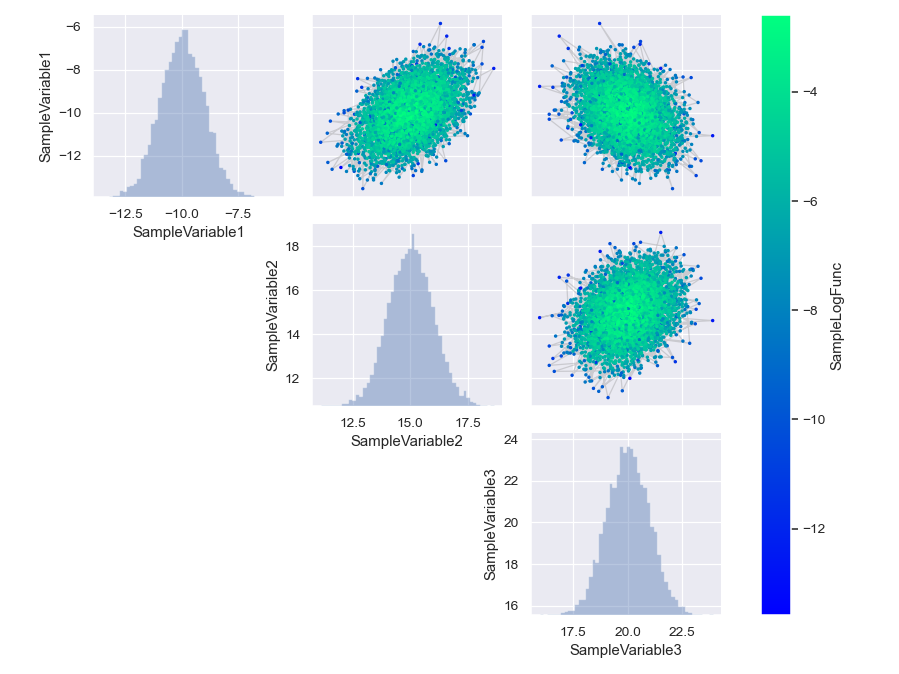

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.19151 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 6: SampleVariable2 - SampleVariable1... done in 1.212235 seconds.
ParaDRAM - NOTE:     2 out of 6: SampleVariable3 - SampleVariable1... done in 1.265872 seconds.
ParaDRAM - NOTE:     3 out of 6: SampleVariable1 - SampleVariable2... done in 1.231785 seconds.
ParaDRAM - NOTE:     4 out of 6: SampleVariable3 - SampleVariable2... done in 1.278929 seconds.
ParaDRAM - NOTE:     5 out of 6: SampleVariable1 - SampleVariable3... done in 1.433824 seconds.
ParaDRAM - NOTE:     6 out of 6: SampleVariable2 - SampleVariable3... done in 1.328548 seconds.


In [28]:
pmpd.sampleList[0].plot.grid()
pmpd.sampleList[0].plot.grid.hide('lower')

To show the triangle again, you can call the `show()` method. To see what input options are available with `hide()` or `show()`, get help like the following,

In [29]:
help(pmpd.sampleList[0].plot.grid.hide)

Help on method hide in module _GridPlot:

hide(part='all') method of _GridPlot.GridPlot instance
    .. py:method:: hide(self, part = "all")
    
    Hides the requested part of the grid plot.
    
    **Parameters**
    
        part
            a string with the following possible values:
    
                "lower"
                    hides the lower triangle of the grid plot.
    
                "upper"
                    hides the upper triangle of the grid plot.
    
                "diag"
                    hides the diagonal of the grid plot.
    
                "all"
                    hides all grid plots and the colorbar.
    
                "cbar"
                    hides the colorbar of the grid plot.
    
                The string can also be a mix of the above keywords, 
                separated by the ``+`` sign or some other delimiter. 
                For example, ``"lower+upper+cbar"``
    
    **Returns**
    
        None



If you'd like to hide the colorbar you can use the `hide` function once again via passing the string "cbar". This completely deletes the colorbar. If you want the colorbar again you will have to either regenerate the plot or use the `show("cbar")` method.

<IPython.core.display.Javascript object>


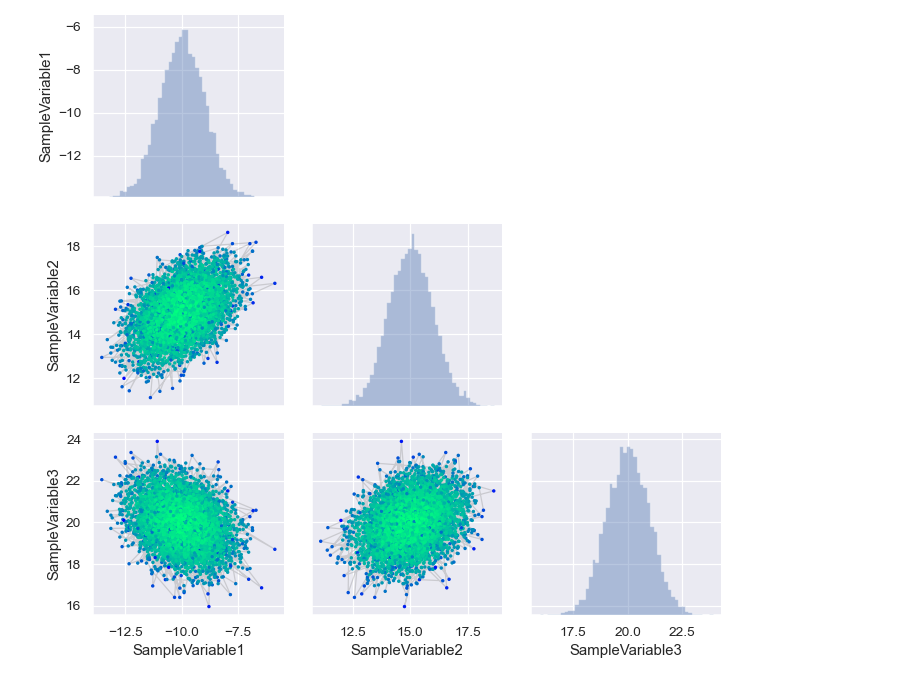

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.057653 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 6: SampleVariable2 - SampleVariable1... done in 1.507018 seconds.
ParaDRAM - NOTE:     2 out of 6: SampleVariable3 - SampleVariable1... done in 2.103609 seconds.
ParaDRAM - NOTE:     3 out of 6: SampleVariable1 - SampleVariable2... done in 1.532585 seconds.
ParaDRAM - NOTE:     4 out of 6: SampleVariable3 - SampleVariable2... done in 1.617314 seconds.
ParaDRAM - NOTE:     5 out of 6: SampleVariable1 - SampleVariable3... done in 1.607792 seconds.
ParaDRAM - NOTE:     6 out of 6: SampleVariable2 - SampleVariable3... done in 1.573698 seconds.


In [30]:
pmpd.sampleList[0].plot.grid(kdecorner=None,lscorner="auto")
pmpd.sampleList[0].plot.grid.hide("upper+cbar")

To compute and visualize the autocorrelation of the sampler points, try,  

<IPython.core.display.Javascript object>


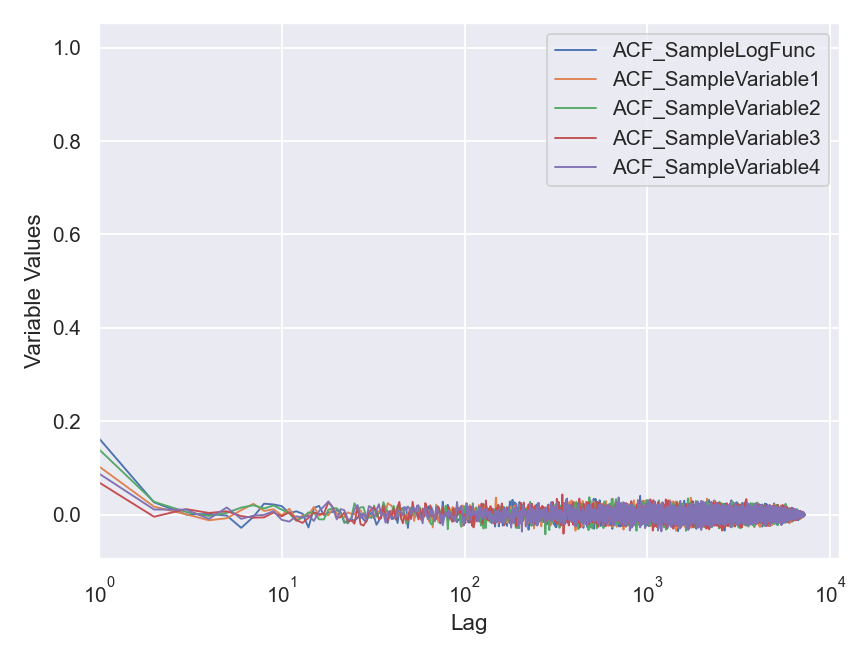

(1, 11295.732769984665)

In [31]:
pmpd.sampleList[0].stats.acf()
pmpd.sampleList[0].stats.acf.plot.line()
pmpd.sampleList[0].stats.acf.plot.line.currentFig.axes.set_xscale("log")
pmpd.sampleList[0].stats.acf.plot.line.currentFig.axes.set_xlim(xmin=1)

The above AutoCorrelation plot is reassuring since the sampled points do not appear to be correlated with each other at all. This is because the ParaDRAM routine, by default, applies as many rounds of Markov chain refinement as necessary to remove any residual correlations from the final output random sample.

To get the statistics of the maximum of the function, try,

In [32]:
print( "maxLogFunc: {}".format(pmpd.sampleList[0].stats.maxLogFunc.value) )
print( "The location of maxLogFunc: {}".format(pmpd.sampleList[0].stats.maxLogFunc.state.values) )

maxLogFunc: -2.5931707000000004
The location of maxLogFunc: [-9.9384628  15.185326   20.176743    0.05430385]


which is again reassuring, since we already know that the maximum of the standard Gaussian distribution happens at zero, which is very close to the ParaDRAM sampler's estimated location of maxLogFunc in the above.

Now, to see the effects of setting the starting point of the MCMC sampler, we will take a look at the full chain (in compact form) of uniquely sampled points form the objective function,

In [33]:
pmpd.readChain()


ParaDRAM - WARNING: delimiter is neither given as input nor set as a ParaDRAM object property.
ParaDRAM - WARNING: This information is essential for successful reading of the requested chain file(s).
ParaDRAM - WARNING: Proceeding with the default assumption of comma-delimited chain file contents...

ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_chain.txt"
ParaDRAM - NOTE: processing file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\jupyter\Python\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_chain.txt
ParaDRAM - NOTE: reading file contents... done in 0.058173 seconds.
ParaDRAM - NOTE: parsing file contents... done in 0.000501 seconds.
ParaDRAM - NOTE: computing sample correlation matrix... done in 0.017546 seconds.
ParaDRAM - NOTE: computing sample covariance matrix... done in 0.015542 seconds.
ParaDRAM - NOTE: computing autocorrelations... done in 0.166442 seco

To make a gridplot you can call the grid object from the set of available plots.  
**warning**: The `kdeplot` of the GridPlot is computationally expensive. To reduce the runtime, either plot smaller chains, or reduce the number of variables in the plot or simply avoid the `kdeplot` by setting the attribute `kdecorner = None`.  

<IPython.core.display.Javascript object>


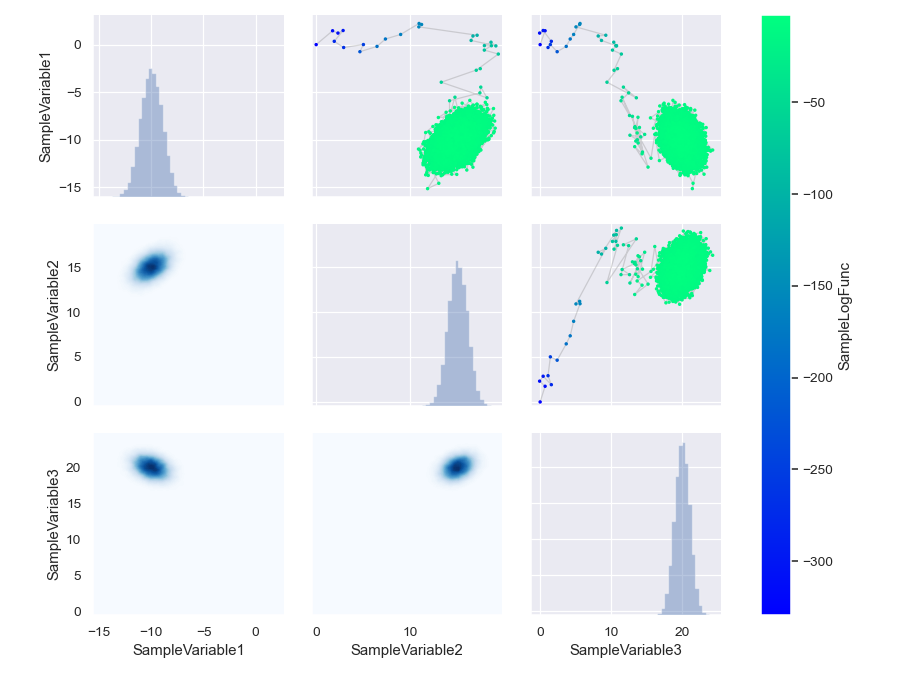

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.090741 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 3: SampleVariable2 - SampleVariable1... done in 1.365664 seconds.
ParaDRAM - NOTE:     2 out of 3: SampleVariable3 - SampleVariable1... done in 1.139555 seconds.
ParaDRAM - NOTE:     3 out of 3: SampleVariable3 - SampleVariable2... done in 1.286315 seconds.
ParaDRAM - NOTE: adding kdeplots... depending on the number of plots, this may take a long while.
ParaDRAM - NOTE:     adding the lower-triangle kdeplots...done in 108.980191 seconds.


In [34]:
pmpd.chainList[0].plot.grid()

The color in the scatter plots represents the value of `logFunc` at each point. The blue color of the density plots represents the density of the sampled points at any given location.  

 We can also add targets to these plots, representing a specific value of interest. For example, we may be interested in displaying the location of the maximum `logFunc` on these plots. This is the default value that is loaded on the targets when the `grid` object is created for the first time.

<IPython.core.display.Javascript object>


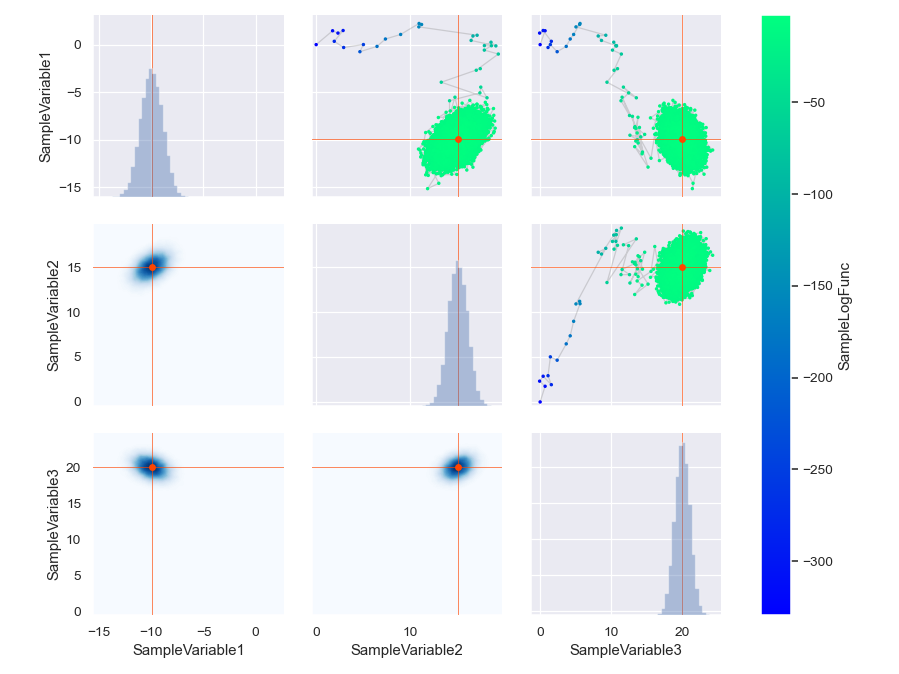

ParaDRAM - NOTE: adding the diagonal histograms (distplots)... done in 0.073195 seconds.
ParaDRAM - NOTE: adding the line/scatter plots...
ParaDRAM - NOTE:     1 out of 3: SampleVariable2 - SampleVariable1... done in 1.195688 seconds.
ParaDRAM - NOTE:     2 out of 3: SampleVariable3 - SampleVariable1... done in 1.13663 seconds.
ParaDRAM - NOTE:     3 out of 3: SampleVariable3 - SampleVariable2... done in 1.107954 seconds.
ParaDRAM - NOTE: adding kdeplots... depending on the number of plots, this may take a long while.
ParaDRAM - NOTE:     adding the lower-triangle kdeplots...done in 90.787247 seconds.


In [35]:
pmpd.chainList[0].plot.grid()
pmpd.chainList[0].plot.grid.addTarget()

Now, let's take a look at the raw Markov Chain,

In [35]:
pmpd.readMarkovChain()


ParaDRAM - WARNING: delimiter is neither given as input nor set as a ParaDRAM object property.
ParaDRAM - WARNING: This information is essential for successful reading of the requested chain file(s).
ParaDRAM - WARNING: Proceeding with the default assumption of comma-delimited chain file contents...

ParaDRAM - NOTE: 1 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_serial*_chain.txt"
ParaDRAM - NOTE: processing file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\jupyter\Python\sampling_multivariate_normal_density_function_via_paradram\mvn_serial_process_1_chain.txt
ParaDRAM - NOTE: reading file contents... done in 6.538811 seconds.
ParaDRAM - NOTE: parsing file contents... done in 0.000502 seconds.
ParaDRAM - NOTE: computing sample correlation matrix... done in 0.062164 seconds.
ParaDRAM - NOTE: computing sample covariance matrix... done in 0.063168 seconds.
ParaDRAM - NOTE: computing autocorrelations... done in 0.639641 seco

To compute and plot the autocorrelation of the Markov chain, try, 

<IPython.core.display.Javascript object>


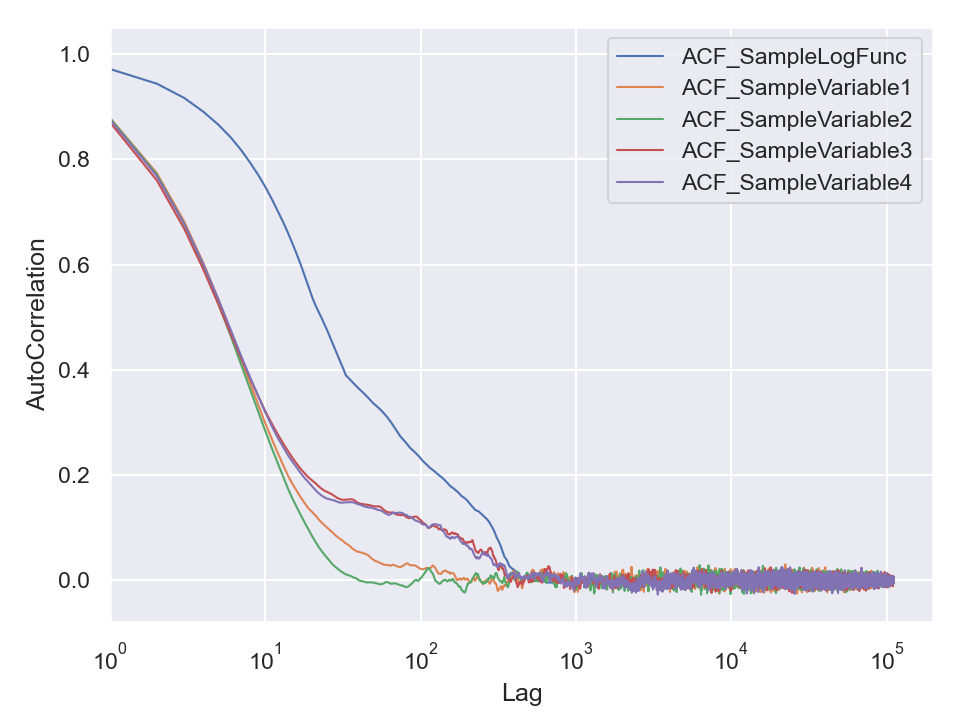

(1, 198579.35020964954)

In [38]:
pmpd.markovChainList[0].stats.acf.plot.line()
pmpd.markovChainList[0].stats.acf.plot.line.currentFig.axes.set_ylabel("AutoCorrelation")
pmpd.markovChainList[0].stats.acf.plot.line.currentFig.axes.set_xscale("log")
pmpd.markovChainList[0].stats.acf.plot.line.currentFig.axes.set_xlim(xmin=1)

**Compare the above plot to the same plot that we got for the resulting refined samples earlier in the above**. Unlike the refined sample, the Markov chain is significantly correlated with itself along each dimension. The large amount of autocorrelation seen for `SampleLogFunc` is because of the fact that we started the MCMC sampling from a very bad low-probability location, which is also visible the grid plots in the above.

To construct and visualize the correlation matrix of the sampled points in the chain, try, 

<IPython.core.display.Javascript object>


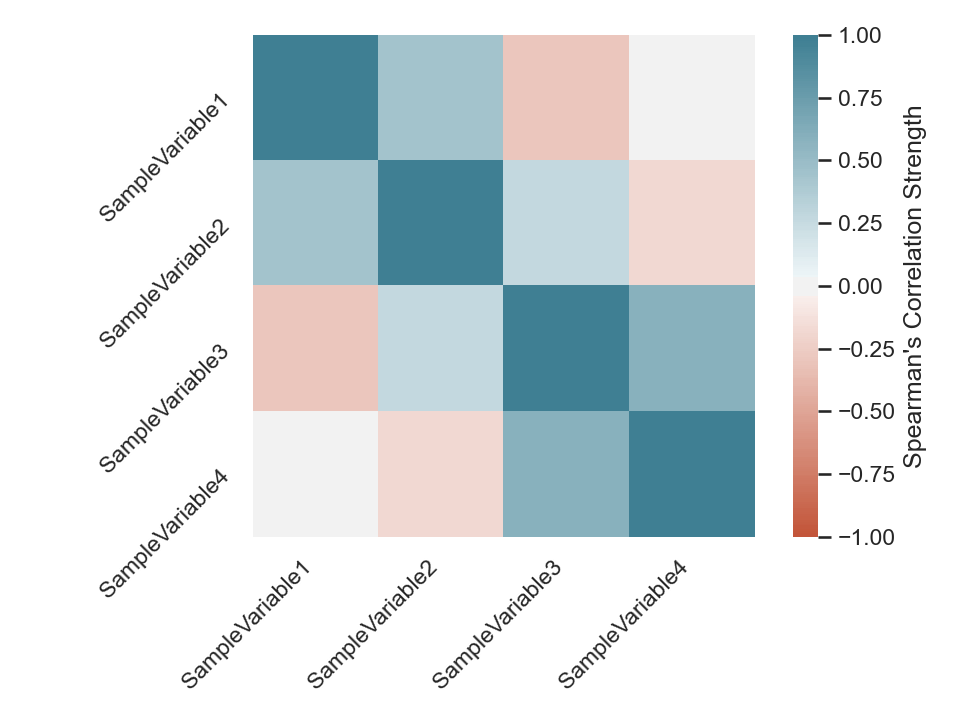

In [39]:
pmpd.markovChainList[0].stats.cormat(method="spearman",reself=True).plot.heatmap()

The input argument `reself` requests the function to **re**turn an instance of the **self** object as the function output.

To construct and visualize the correlation matrix of the Markov chain, try, 

<IPython.core.display.Javascript object>


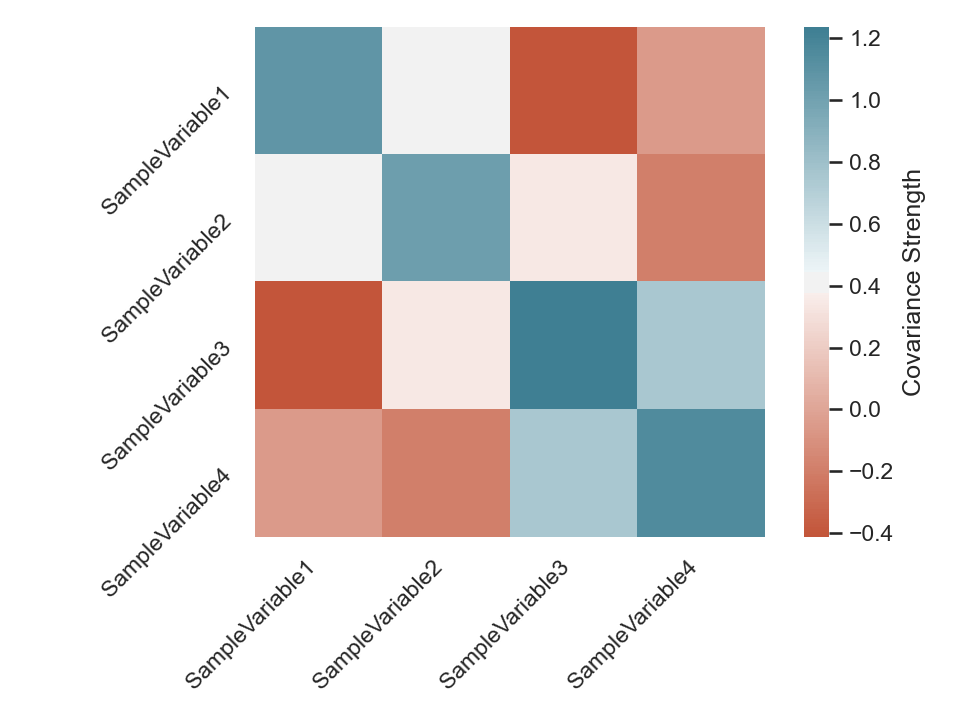

In [40]:
pmpd.markovChainList[0].stats.covmat(reself=True).plot.heatmap()

For comparison, here is the correlation matrix of the refined sampled points in the sample file, 

<IPython.core.display.Javascript object>


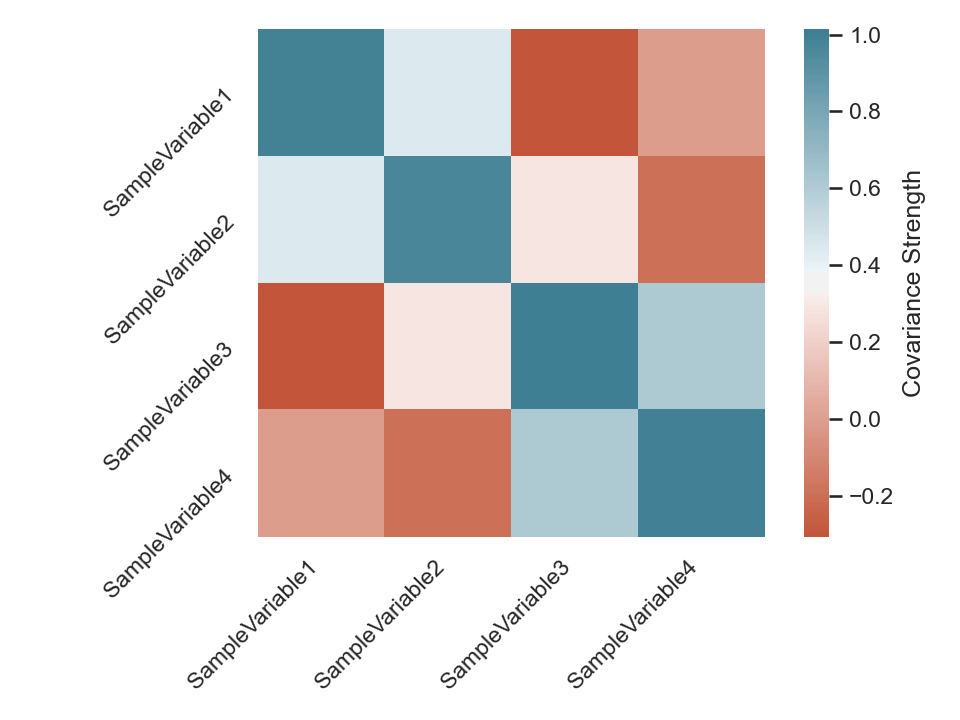

In [41]:
pmpd.sampleList[0].stats.covmat(reself=True).plot.heatmap()

The two plots are mostly consistent with each other, an indication that good convergence has occurred, and that the requested chainSize of 30000 unique points was more than enough to obtain a reasonable number i.i.d. random samples from the objective function.

## Running a single-chain ParaDRAM simulation in parallel on multiple processors
As a final note, if you want to run the above simulation in parallel, you will have to save the Python scripts in an external Python file. The following code will save the relevant scripts in an external file named `main_mpi.py`,

In [1]:
# First, ensure the output folder for this example already exists
!mkdir sampling_multivariate_normal_density_function_via_paradram

A subdirectory or file sampling_multivariate_normal_density_function_via_paradram already exists.


In [2]:
with open("./sampling_multivariate_normal_density_function_via_paradram/main_mpi_singleChain.py","w") as file:
    contents = """
import numpy as np

NDIM = 4 # the number of dimensions of the domain of the objective function: MVN

MEAN =  np.double([-10, 15., 20., 0.0]) # This is the mean of the MVN distribution.

COVMAT = np.double( [ [1.0,.45,-.3,0.0] 
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] ) # This is the covariance matrix of the MVN distribution.

INVCOV = np.linalg.inv(COVMAT) # This is the inverse of the covariance matrix of the MVN distribution.

# This is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point): 
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

import paramonte as pm

pmpd = pm.ParaDRAM() # define a ParaMonte sampler instance

pmpd.mpiEnabled = True # This is essential as it enables the invocation of the MPI-parallelized ParaDRAM routines.

pmpd.spec.randomSeed = 3751 # initialize the random seed to generate reproducible results.
pmpd.spec.outputFileName = "./mvn_parallel_singleChain"
pmpd.spec.progressReportPeriod = 20000
pmpd.spec.chainSize = 30000 # the default 100,000 unique points is too large for this simple example, so set it to 30000.

# call the ParaDRAM sampler

pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )
"""
    file.write(contents)

Here is the saved [output MPI-parallelized Python script](./sampling_multivariate_normal_density_function_via_paradram/main_mpi_singleChain.py).
> **Note** the additional ParaDRAM-object's attribute `mpiEnabled = True` causes the sampler to invoke the Mpi-parallelized version of the ParaDRAM sampler routine, causing the simulation to run in parallel.

**IMPORTANT**: At this, we assume that you have already an MPI runtime library installed on your system. We highly recommend the installation of Intel MPI on your system if it is Windows or Linux, and Open-MPI if it is macOS. You can run `pm.verify()` on your python command line, just as described earlier in this notebook, to verify the existence of the MPI library on your system.

We will now run this code in parallel on 3 processors. We will invoke the `mpiexe` launcher to run the code in parallel,, however, depending on your system, your platform, or the supercomputer on which you are running this code, you may need a different MPI launcher (e.g., `ibrun`, `mpirun`, ...). We will assume in the following that you will be using the Intel MPI library if your operating system is Windows.

Now, we run the MPI-enabled Python script in parallel on three cores, **on the terminal** (not in the Python session),  

In [3]:
!cd sampling_multivariate_normal_density_function_via_paradram && \
ls && mpiexec -n 3 python main_mpi_singleChain.py || mpiexec -localonly -n 3 python main_mpi_singleChain.py

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                                                          ****
****                                                  Plain Powerful Parallel                                                   ****
****                                                    Monte Carlo Library                                                     ****
****                                                               

'ls' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file .\ already exists.


This will again, as expected, generate 5 output files that are [accessible here](sampling_multivariate_normal_density_function_via_paradram/), all prefixed with `mvn_parallel_singleChain_*`. In particular, the [simulation report file](sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_singleChain_process_1_report.txt) contains a lot of interesting information about the performance of the parallel simulation, part of which is given below, 

```text
Total number of accepted function calls (unique samples):
30000
 
 
Total number of accepted or rejected function calls:
106901
 
 
Total number of accepted or rejected or delayed-rejection (if any requested) function calls:
106901
 
 
Total number of accepted or rejected or unused function calls (by all processes, including delayed rejections, if any requested):
143763
 
 
Average MCMC acceptance rate:
0.281683694071886
 
 
MCMC sampling efficiency [ = acceptedFunctionCalls / acceptedPlusRejectedFunctionCalls ]:
0.280633483316339
 
 
MCMC sampling efficiency (including delayed rejections, if any requested) [ = acceptedFunctionCalls / acceptedPlusRejectedPlusDelayedRejectionFunctionCalls ]:
0.280633483316339
 
 
Total runtime in seconds:
1.83999991416931
 
 
Average effective time cost of each accepted function call, in seconds:
6.133333047231038E-005
 
 
Average effective time cost of each accepted or rejected function call, in seconds:
1.721218617383665E-005
 
 
Average effective time cost of each accepted or rejected or unused function call (including delayed-rejections, if any requested), in seconds:
1.279884194242824E-005
 
 
Average time cost of inter-process communications per used (accepted or rejected or delayed-rejection) function call, in seconds:
3.657569963402726E-006
 
 
Average pure time cost of each function call, in seconds:
1.558810034045189E-005
 
 
Number of processes (images):
3
 
 
Estimated maximum speedup gained via singleChain parallelization model compared to serial mode:
1.46788562123638
 
 
Predicted optimal number of physical computing processes for singleChain parallelization model, given the current MCMC sampling efficiency:
3
 
 
Predicted optimal maximum speedup gained via singleChain parallelization model, given the current MCMC sampling efficiency:
1.46788562123638
 
 
Predicted absolute optimal number of physical computing processes for singleChain parallelization model, under any MCMC sampling efficiency:
3
 
 
Predicted absolute optimal maximum speedup gained via singleChain parallelization model, under any MCMC sampling efficiency:
1.76065039487641
 
        ParaDRAM - NOTE: This simulation will likely NOT benefit from any additional computing processor beyond the predicted 
        ParaDRAM - NOTE: absolute optimal number, 3, in the above. This is true for any value of MCMC sampling efficiency.
 
 
Burnin location in the compact chain, based on the occurrence likelihood:
35
 
 
Burnin location in the compact chain, based on the value of burninAdaptationMeasure:
1
 
 
Burnin location in the verbose (Markov) chain, based on the occurrence likelihood:
209
 
 
Burnin location in the verbose (Markov) chain, based on the value of burninAdaptationMeasure:
1
 
 
Location of the first occurrence of maximum-logFunc in the compact chain:
24829
 
 
Location of the first occurrence of maximum-logFunc in the verbose (Markov) chain:
90119
 
 
Maximum-logFunc value (maximum of the user-specified objective function):
-2.57346904204418
 
 
Maximum-logFunc coordinates (mode of the user-specified objective function):
         SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
         -0.10081221E+02          0.14979843E+02          0.20058795E+02         -0.16505427E-01
 
 
************************************************************************************************************************************
****                                                                                                                            ****
****                                           Markov chain's statistical properties                                            ****
****                                                                                                                            ****
************************************************************************************************************************************
 
 
length of the Markov Chain excluding burnin:
106693
 
 
Mean and standard deviation of the Markov chain variables:
                                            Mean      Standard Deviation
         SampleVariable1         -0.99875380E+01          0.98961179E+00
         SampleVariable2          0.15007569E+02          0.99847593E+00
         SampleVariable3          0.19991850E+02          0.10072892E+01
         SampleVariable4         -0.26308131E-02          0.10024217E+01
 
 
Covariance matrix of the Markov chain:
                                 SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
         SampleVariable1          0.97933150E+00          0.45361645E+00         -0.29884810E+00         -0.18506684E-01
         SampleVariable2          0.45361645E+00          0.99695418E+00          0.30055332E+00         -0.19925329E+00
         SampleVariable3         -0.29884810E+00          0.30055332E+00          0.10146316E+01          0.61433765E+00
         SampleVariable4         -0.18506684E-01         -0.19925329E+00          0.61433765E+00          0.10048492E+01
 
 
Correlation matrix of the Markov chain:
                                 SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
         SampleVariable1          0.10000000E+01          0.45907784E+00         -0.29979988E+00         -0.18655775E-01
         SampleVariable2          0.45907784E+00          0.10000000E+01          0.29883382E+00         -0.19907534E+00
         SampleVariable3         -0.29979988E+00          0.29883382E+00          0.10000000E+01          0.60841864E+00
         SampleVariable4         -0.18655775E-01         -0.19907534E+00          0.60841864E+00          0.10000000E+01
 
 
Quantiles of the Markov chain variables:
                Quantile         SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
                      0%         -0.14135556E+02          0.10964801E+02          0.15731022E+02         -0.41694986E+01
                      5%         -0.11614777E+02          0.13361597E+02          0.18336570E+02         -0.16361807E+01
                     10%         -0.11261375E+02          0.13732577E+02          0.18705404E+02         -0.12860789E+01
                     25%         -0.10655652E+02          0.14348010E+02          0.19323080E+02         -0.69392326E+00
                     50%         -0.99842541E+01          0.15011768E+02          0.19981336E+02         -0.58325058E-02
                     75%         -0.93289671E+01          0.15674896E+02          0.20686384E+02          0.69485641E+00
                     90%         -0.87222468E+01          0.16293743E+02          0.21284817E+02          0.12763519E+01
                     95%         -0.83666805E+01          0.16663319E+02          0.21650884E+02          0.16277000E+01
                    100%         -0.57221117E+01          0.19058108E+02          0.23956477E+02          0.41926633E+01
 
 
Integrated Autocorrelation (IAC) of the Markov chain:
         RefinementStage              SampleSize       IAC_SampleLogFunc     IAC_SampleVariable1     IAC_SampleVariable2     IAC_SampleVariable3     IAC_SampleVariable4
                       0                  106901          0.76061196E+01          0.31476701E+01          0.25294247E+01          0.47839768E+01          0.69871597E+01
                       1                   14027          0.26715695E+01          0.15457420E+01          0.16540838E+01          0.19860874E+01          0.20522166E+01
                       2                    5250          0.13143344E+01          0.17063641E+01          0.88797466E+00          0.15147121E+01          0.10091294E+01
 
 
Estimated Effective (decorrelated) Sample Size (ESS):
5250
 
 
Effective sampling efficiency ( = effectiveSampleSize / acceptedPlusRejectedFunctionCalls ):
4.911085958035940E-002
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: .\mvn_parallel_singleChain_process_1_sample.txt
 
 
 
************************************************************************************************************************************
****                                                                                                                            ****
****                                           Output sample's statistical properties                                           ****
****                                                                                                                            ****
************************************************************************************************************************************
 
 
Final output sample size:
5250
 
 
Mean and standard deviation of the output sample:
                                            Mean      Standard Deviation
         SampleVariable1         -0.99917131E+01          0.98844084E+00
         SampleVariable2          0.15021747E+02          0.99204889E+00
         SampleVariable3          0.19992897E+02          0.10160342E+01
         SampleVariable4         -0.12638687E-01          0.10034157E+01
 
 
Covariance matrix of the output sample:
                                 SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
         SampleVariable1          0.97701529E+00          0.45376763E+00         -0.31427350E+00         -0.27680494E-01
         SampleVariable2          0.45376763E+00          0.98416101E+00          0.29308171E+00         -0.18848922E+00
         SampleVariable3         -0.31427350E+00          0.29308171E+00          0.10323254E+01          0.63052954E+00
         SampleVariable4         -0.27680494E-01         -0.18848922E+00          0.63052954E+00          0.10068431E+01
 
 
Correlation matrix of the output sample:
                                 SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
         SampleVariable1          0.10000000E+01          0.46275354E+00         -0.31293113E+00         -0.27908871E-01
         SampleVariable2          0.46275354E+00          0.10000000E+01          0.29076847E+00         -0.18935316E+00
         SampleVariable3         -0.31293113E+00          0.29076847E+00          0.10000000E+01          0.61846657E+00
         SampleVariable4         -0.27908871E-01         -0.18935316E+00          0.61846657E+00          0.10000000E+01
 
 
Quantiles of the output sample's variables:
                Quantile         SampleVariable1         SampleVariable2         SampleVariable3         SampleVariable4
                      0%         -0.14131308E+02          0.11172583E+02          0.16037984E+02         -0.41694986E+01
                      5%         -0.11599583E+02          0.13403633E+02          0.18319714E+02         -0.16786751E+01
                     10%         -0.11256654E+02          0.13750277E+02          0.18713251E+02         -0.12819920E+01
                     25%         -0.10665662E+02          0.14371220E+02          0.19318895E+02         -0.67936138E+00
                     50%         -0.99853993E+01          0.15023241E+02          0.19991138E+02         -0.29425853E-01
                     75%         -0.93317023E+01          0.15675893E+02          0.20698713E+02          0.68167587E+00
                     90%         -0.87430139E+01          0.16305625E+02          0.21302839E+02          0.12631959E+01
                     95%         -0.83903445E+01          0.16683983E+02          0.21638525E+02          0.16332186E+01
                    100%         -0.60273146E+01          0.18385342E+02          0.23495506E+02          0.33353531E+01
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
```  

### The efficiency of the parallel simulation  

As you can see in the report, the **Estimated maximum speedup gained via singleChain parallelization model compared to serial mode**, was only moderate (`1.46788562123638`). This is partly because the example objective function here is too easy to compute and partly because this simulation was performed on a decent fast quad-core processor.  

But, more importantly, note the **Predicted absolute optimal maximum speedup gained via singleChain parallelization model, under any MCMC sampling efficiency: `1.76065039487641`**, which tells us that no matter how you configure this simulation, the speedup gained by running this simulation in parallel can be **at most** a factor of `~1.8` better than the performance of the serial run of the same problem with the same simulation specifications, **regardless of how many CPU cores you may use for the parallel simulation**.  

The report also tells us that the **Predicted absolute optimal number of physical computing processes for singleChain parallelization model, under any MCMC sampling efficiency** is 3. No more cores will have any help to improve the efficiency parallel run of this particular problem.  

**The ability of the sampler to give us such detailed efficiency reports is remarkable as it can help you set up your parallel simulations more reasonably and optimally, without wasting any extra computational resources with not efficiency gain.** When you are working with expensive large-scale simulations, it is, therefore, a good idea to run some tests of your simulation and check the output of the report file to find the predicted optimal number of physical cores for the parallel simulation and then, request the same number of cores as predicted when invoking the MPI launcher.  

## Running a multi-chain ParaDRAM simulation in parallel on multiple processors  
There is another mode of parallelization, the **multi-chain** mode, by which the ParaDRAM sampler can sample points from the objective function. In this mode, the sampler will generate multiple chains, each corresponding to one physical core on the computer. Each of these chains will independently explore the domain of the objective function.  

To make the exploration even more interesting and robust (i.e., to ensure convergence to the target objective function by all independent chains), we can also let the initial starting point of the MCMC sampler to be chosen at random. To do so, we will have to also specify a domain from which the initial random start points will be sampled, otherwise, the default domain extends from negative infinity to positive infinity, which is problematic for computer simulations, 

In [4]:
# First, ensure the output folder for this example already exists
!mkdir sampling_multivariate_normal_density_function_via_paradram

A subdirectory or file sampling_multivariate_normal_density_function_via_paradram already exists.


In [5]:
with open("./sampling_multivariate_normal_density_function_via_paradram/main_mpi_multiChain.py","w+") as file:
    contents = """
import numpy as np

NDIM = 4 # the number of dimensions of the domain of the objective function: MVN

MEAN =  np.double([-10, 15., 20., 0.0]) # This is the mean of the MVN distribution.

COVMAT = np.double( [ [1.0,.45,-.3,0.0] 
                    , [.45,1.0,0.3,-.2]
                    , [-.3,0.3,1.0,0.6]
                    , [0.0,-.2,0.6,1.0]
                    ] ) # This is the covariance matrix of the MVN distribution.

INVCOV = np.linalg.inv(COVMAT) # This is the inverse of the covariance matrix of the MVN distribution.

# This is the log of the coefficient used in the definition of the MVN.

MVN_COEF = NDIM * np.log( 1. / np.sqrt(2.*np.pi) ) + np.log( np.sqrt(np.linalg.det(INVCOV)) )

# the logarithm of objective function: log(MVN)

def getLogFunc(point): 
    normedPoint = MEAN - point
    return MVN_COEF - 0.5 * ( np.dot(normedPoint,np.matmul(INVCOV,normedPoint)) )

import paramonte as pm

pmpd = pm.ParaDRAM() # define a ParaMonte sampler instance

pmpd.mpiEnabled = True # This is essential as it enables the invocation of the MPI-parallelized ParaDRAM routines.

pmpd.spec.randomSeed = 3751 # initialize the random seed to generate reproducible results.
pmpd.spec.outputFileName = "./mvn_parallel_multiChain"
pmpd.spec.progressReportPeriod = 20000
pmpd.spec.chainSize = 30000 # the default 100,000 unique points is too large for this simple example, so set it to 30000.

# set up a random initial starting point for each of the independent MCMC chains,
# by defining the domain of the random start points. The following defines the 
# boundaries of the NDIM(=four)-dimensional hypercube from within which the 
# random initial start points will be drawn by the sampler,

pmpd.spec.randomStartPointRequested = True # This is essential, otherwise, random initialization won't happen
pmpd.spec.randomStartPointDomainLowerLimitVec = NDIM * [-25]
pmpd.spec.randomStartPointDomainUpperLimitVec = NDIM * [+25]

# set the parallelization model to multichain

pmpd.spec.parallelizationModel = "multi chain" # the value is case and white-space insensitive

# call the ParaDRAM sampler

pmpd.runSampler ( ndim = 4
                , getLogFunc = getLogFunc
                )
"""
    file.write(contents)

Now, we run the MPI-enabled Python script in parallel on three cores, **on the terminal** (not in the Python session),  

In [6]:
!cd sampling_multivariate_normal_density_function_via_paradram && \
ls && mpiexec -n 3 python main_mpi_multiChain.py || mpiexec -localonly -n 3 python main_mpi_multiChain.py

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                                                          ****
****                                                  Plain Powerful Parallel                                                   ****
****                                                    Monte Carlo Library                                                     ****
****                                                               

'ls' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file .\ already exists.


Unlike the previous simulations, serial or `singleChain`-parallel, the `multiChain`-parallel ParadRAM simulation generates `5 * number_of_cores` [output files (prefixed by `mvn_parallel_multiChain*`)](sampling_multivariate_normal_density_function_via_paradram/) on the system, separated from each other by their processor IDs (starting from 1).  

#### The Kolmogorov-Smirnov test of similarity of the independent samples from the independent MCMC chains

By looking at the end of any of the output `_report.txt` files, we will notice that the Kolmogorov-Smirnov (KS) probabilities of the similarities of pairs of these independent samples from indepedent MCMC chains is generally quite high, indicating the high level of similarities between the independent samples obtained from the independent MCMC chains. **This means that there is no evidence of the lack of convergence of the MCMC samples to the target objective function**. We know this for sure in this particular example, because the structure of the objective function is known to us. In other problems, however, this may never be known, in other words, *we can just hope that the convergence has occurred*.

Here is a KS-probability-table excerpt from the first processor's output `*_report.txt` file,

```text  
        ParaDRAM - NOTE: Computing the inter-chain convergence probabilities...
 
 
Pairwise inter-chain Kolmogorov-Smirnov (KS) convergence (similarity) probabilities:
               ProcessID   probKS(SampleLogFunc) probKS(SampleVariable1) probKS(SampleVariable2) probKS(SampleVariable3) probKS(SampleVariable4)
                       2          0.67535922E+00          0.68652234E+00          0.47581363E+00          0.14260518E+00          0.91895363E-03
                       3          0.49576540E+00          0.91869313E+00          0.99443834E+00          0.35252163E+00          0.15053954E+00
 
        ParaDRAM - NOTE: Higher KS probabilities are better, indicating less evidence for a lack of convergence.
 
 
Smallest KS probability for the inter-chain sampling convergence:
9.189536316315983E-004 for SampleVariable4 on the chains generated by processes 1 and 2.
```  

We can also read and visualize the results of these parallel runs just as before,

In [7]:
import paramonte as pm
pmpd = pm.ParaDRAM()
pmpd.readMarkovChain(file = "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain_*")


ParaDRAM - WARNING: delimiter is neither given as input nor set as a ParaDRAM object property.
ParaDRAM - WARNING: This information is essential for successful reading of the requested chain file(s).
ParaDRAM - WARNING: Proceeding with the default assumption of comma-delimited chain file contents...

ParaDRAM - NOTE: 3 files detected matching the pattern: "./sampling_multivariate_normal_density_function_via_paradram/mvn_parallel_multiChain_*_chain.txt"
ParaDRAM - NOTE: processing file: D:\Dropbox\Projects\20180101_ParaMonte\paramontex\jupyter\Python\sampling_multivariate_normal_density_function_via_paradram\mvn_parallel_multiChain_process_1_chain.txt
ParaDRAM - NOTE: reading file contents... done in 5.379693 seconds.
ParaDRAM - NOTE: parsing file contents... done in 0.000501 seconds.
ParaDRAM - NOTE: computing sample correlation matrix... done in 0.098764 seconds.
ParaDRAM - NOTE: computing sample covariance matrix... done in 0.083223 seconds.
ParaDRAM - NOTE: computing autocorrelatio

Let's make a trace plot of the first Markov chain,

In [13]:
# activate interactive plotting in Jupyter environment
%matplotlib notebook

<IPython.core.display.Javascript object>


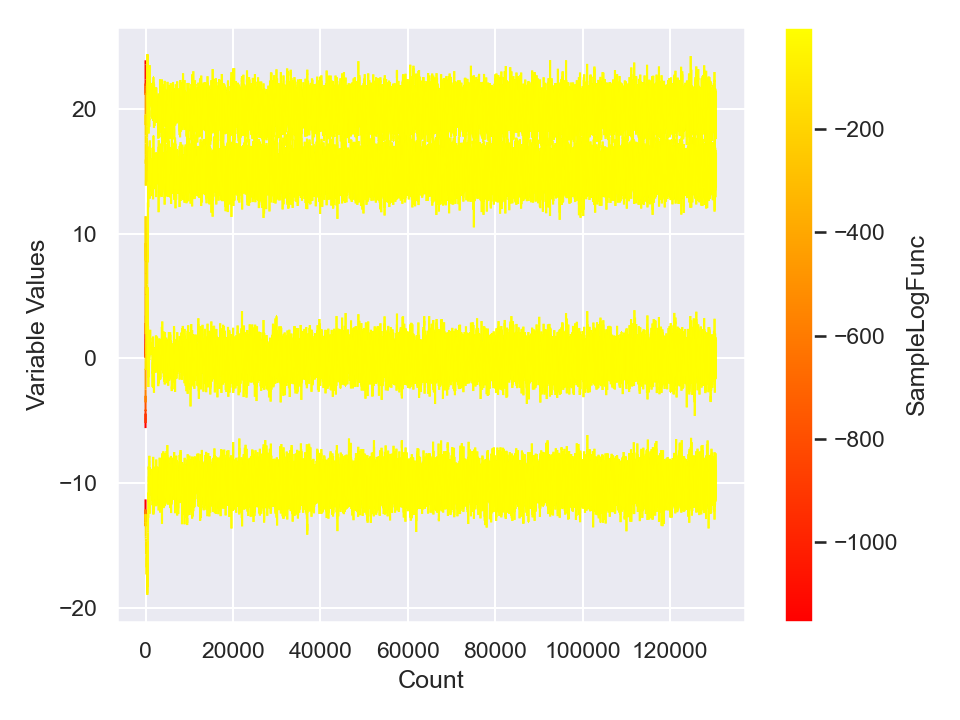

In [9]:
pmpd.markovChainList[0].plot.line()

Let's take the log of the x-axis for better visualization,

<IPython.core.display.Javascript object>


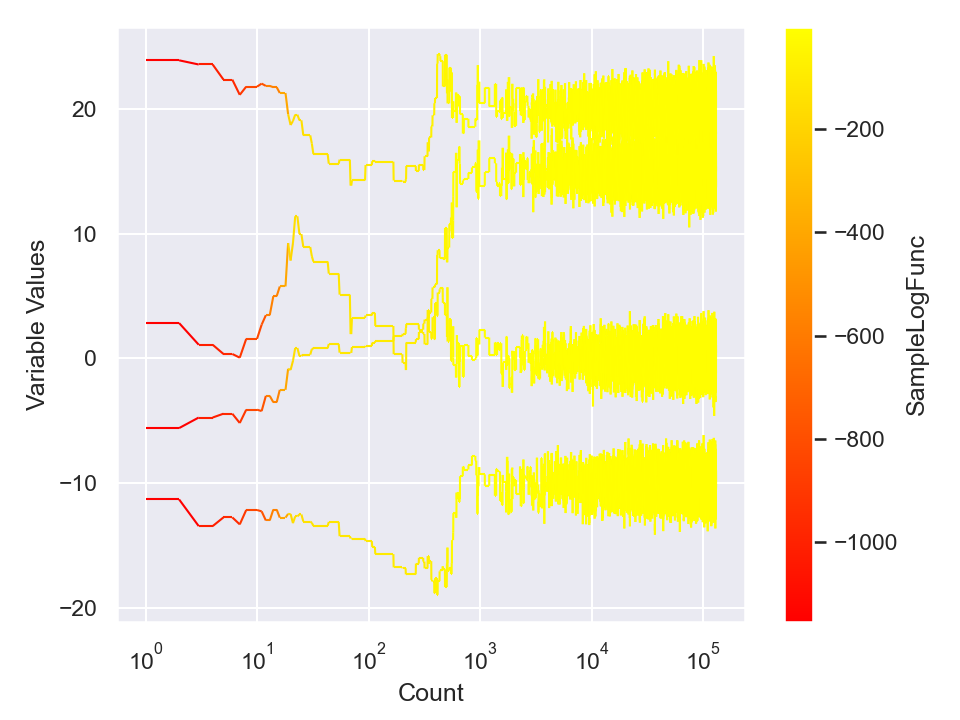

In [10]:
pmpd.markovChainList[0].plot.line()
pmpd.markovChainList[0].plot.line.currentFig.axes.set_xscale("log")

We can compare this plot with the resulting Markov chain from, say, processor #3,

<IPython.core.display.Javascript object>


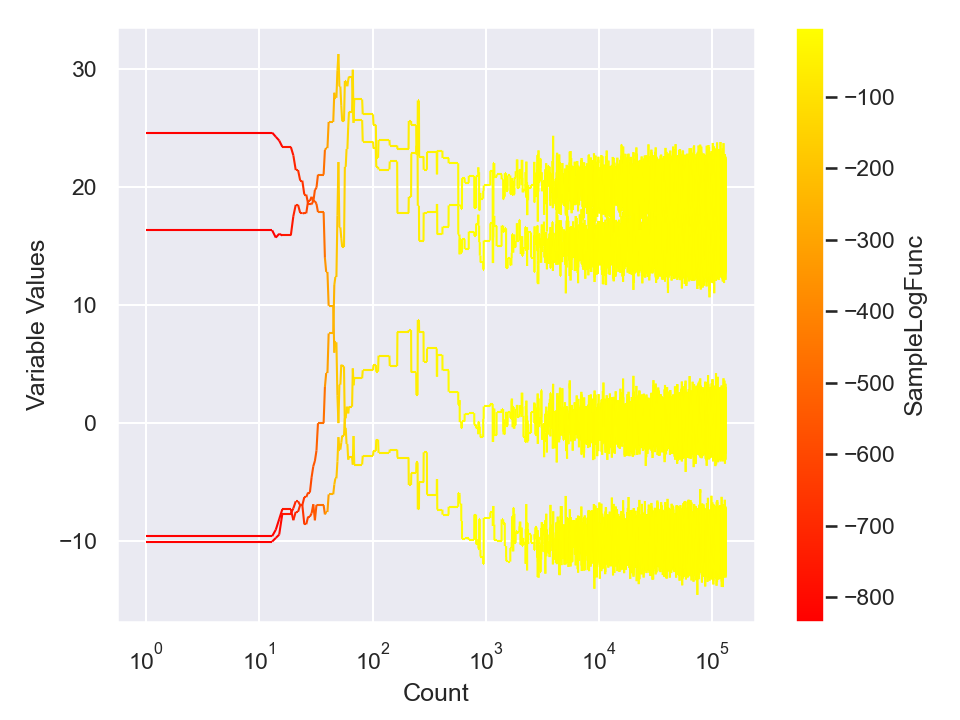

In [11]:
pmpd.markovChainList[2].plot.line()
pmpd.markovChainList[2].plot.line.currentFig.axes.set_xscale("log")

Clearly, the MCMC chains, despite being initialized at completely-random starting points, converge toward each other along each dimension, which is a good sign, potentially implying the convergence of the MCMC chains to the target objective function, here, the MVN probability density function.

>**There are many more functionalities and features of the ParaMonte library that were neither explored nor mentioned in this example Jupyter notebook. You can explore them by checking the existing components of each attribute of the ParaDRAM sampler class and by visiting the [ParaMonte library's documentation website](http://cdslab.org/paramonte/)**.